In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import os
import re
import cv2
import time
import cv3

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)

ImportError: libwebp.so.4: cannot open shared object file: No such file or directory

In [457]:
results_dir = '../darknet/parse/parsed'
data_dir = '../orig_data'
results = [name for name in os.listdir(results_dir) if os.path.isfile(os.path.join(results_dir, name))]

In [92]:
def scale_box(df, im):
    predict_im_size = 832.
    df.columns = ['prob', 'x', 'y', 'w', 'h']

    # Vertical is stretched as the same as width, rest is filled with blank space
    im_height, im_width, _ = im.shape
    width_scale = im_width / predict_im_size
    height_scale = im_height / predict_im_size
    scale_diff = (predict_im_size - (im_height / width_scale)) / 2.
    
    df.iloc[:,[1,3]] = np.round(df.iloc[:,[1,3]] * width_scale)
    df.iloc[:,[2,4]] = np.round((df.iloc[:,[2,4]] - scale_diff) * width_scale)
    df.iloc[:,3] = df.iloc[:,3] - df.iloc[:,1]
    df.iloc[:,4] = df.iloc[:,4] - df.iloc[:,2]
    
    return df

In [4]:
def show_image(im):
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.] )
    ax.set_axis_off( )
    fig.add_axes(ax)
    
    ax.imshow(im)
    return ax

In [134]:
def xywh_2_ltbr(df):
    df = df.copy(deep=True)
    df.columns = ['prob', 'x1', 'y1', 'x2', 'y2']
    df.iloc[:,3] = df.iloc[:,3] + df.iloc[:,1]
    df.iloc[:,4] = df.iloc[:,4] + df.iloc[:,2]
    
    return df

def ltbr_2_xywh(df):
    df = df.copy(deep=True)
    df.columns = ['prob', 'x', 'y', 'w', 'h']
    df.iloc[:,3] = df.iloc[:,3] - df.iloc[:,1]
    df.iloc[:,4] = df.iloc[:,4] - df.iloc[:,2]
    
    return df

In [347]:
def is_intersecting(df):
    df = xywh_2_ltbr(df)
    result_array = []
    for index, data in df.iterrows():
        result = np.array(np.logical_not((df.x1 > data.x2) |
                                         (df.x2 < data.x1) | 
                                         (df.y1 > data.y2) | 
                                         (df.y2 < data.y1)))
        result_array = np.append(result_array, result)
    result_array = result_array.reshape((df.shape[0], df.shape[0]))
    np.fill_diagonal(result_array, 0)
    return result_array

def pick_max(df, value):
    df = df.copy(deep = True)
    return df.map(lambda x: x if x >= value else value)

def pick_min(df, value):
    df = df.copy(deep = True)
    return df.map(lambda x: x if x <= value else value)

def box_and_overlap_area(df, conversion = False):
    if conversion is True:
        df_ltbr = xywh_2_ltbr(df)
    else:
        df_ltbr = df.copy(deep = True)
        df_ltbr.columns = ['prob', 'x1', 'y1', 'x2', 'y2']
    
    result_array = []
    for index, data in df_ltbr.iterrows():
        left = pick_max(df_ltbr['x1'], data.x1)
        right = pick_min(df_ltbr['x2'], data.x2)
        top = pick_max(df_ltbr['y1'], data.y1)
        bot = pick_min(df_ltbr['y2'], data.y2)
        
        height = pick_max((bot - top), 0)
        width = pick_max((right - left), 0)
        
        result_array = np.append(result_array, height * width)
    result_array = result_array.reshape((df.shape[0], df.shape[0]))
    
    return result_array

def separate_box_and_overlap(combined):
    box_area = np.diagonal(combined).copy()
    np.fill_diagonal(combined, 0)
    
    return box_area, combined

def overlap_area(df):
    overlap_area = box_and_overlap_area(df)
    np.fill_diagonal(overlap_area, 0)
    return overlap_area

def box_area(df):
    box_area = box_and_overlap_area(df)
    return np.diagonal(box_area)

def overlap_percentage(df):
    combined = box_and_overlap_area(df)
    box_area, overlap_area = separate_box_and_overlap(combined)

    iu1 = np.triu_indices(overlap_area.shape[0])
    overlap_area[iu1] = 0
    overlap_coordinates = np.nonzero(overlap_area)
    
    box1, box2 = overlap_coordinates
    
    result_array = []
    for i in xrange(box1.shape[0]):
        specific_overlap_area = overlap_area[box1[i], box2[i]]
        total_area = box_area[box1[i]] + box_area[box2[i]] - specific_overlap_area
        percentage = specific_overlap_area / total_area
        result_array.append(percentage)
    
    return result_array    

In [551]:
def calculate_mid_point(df, conversion = False):
    if conversion is True:
        df_ltbr = xywh_2_ltbr(df)
    else:
        df_ltbr = df.copy(deep = True)
        df_ltbr.columns = ['prob', 'x1', 'y1', 'x2', 'y2']
    mid_x = (df_ltbr.x1 + df_ltbr.x2) / 2.
    mid_y = (df_ltbr.y1 + df_ltbr.y2) / 2.
    
    new_frame = pd.concat([mid_x, mid_y], axis = 1)
    new_frame.columns = ['x', 'y']
    
    return new_frame

def calculate_distance_from_each(midpoint_df):
    result_array = []
    for index, data in midpoint_df.iterrows():
        diff = midpoint_df - data
        diff = diff.applymap(lambda x: np.power(x,2))
        diff = np.sqrt(diff.sum(axis = 1))
        result_array = np.append(result_array, diff)
    result_array = result_array.reshape((dist_df.shape[0], dist_df.shape[0]))
    print result_array

def calculate_dist_between_frame(curr_frame, next_frame):
    result_array = []
    for index, data in curr_frame.iterrows():
        diff = next_frame - data
        diff = diff.applymap(lambda x: np.power(x,2))
        diff = np.sqrt(diff.sum(axis = 1))
        result_array = np.append(result_array, diff)
    result_array = result_array.reshape((curr_frame.shape[0], next_frame.shape[0]))
    return result_array

In [559]:
keep = pd.DataFrame(np.nan, index=range(0,10), columns=['x', 'y'])
print keep

    x   y
0 NaN NaN
1 NaN NaN
2 NaN NaN
3 NaN NaN
4 NaN NaN
5 NaN NaN
6 NaN NaN
7 NaN NaN
8 NaN NaN
9 NaN NaN


In [642]:
def reorder_df(players, curr):
    print players
    new_players = players.copy(deep = True)
    dist = calculate_dist_between_frame(players, curr)
    assignment = np.argmin(dist, axis = 1)
    for index, data in new_players.iterrows():
        if np.isnan(data['x']) is False:
            data['x'] = players.iloc[assignment[index], 0]
            data['y'] = players.iloc[assignment[index], 1]
    return new_players, assignment

       x      y
0  155.0  521.0
1  218.5  528.0
2  258.0  523.5
3  282.0  520.5
4   80.0  576.0
5  107.5  578.0
6  148.0  597.5
7  940.0  634.5
8  872.5  654.0
9    NaN    NaN
       x      y
0  155.0  521.0
1  218.5  528.0
2  258.0  523.5
3  282.0  520.5
4   80.0  576.0
5  107.5  578.0
6  148.0  597.5
7  940.0  634.5
8  872.5  654.0
9    NaN    NaN


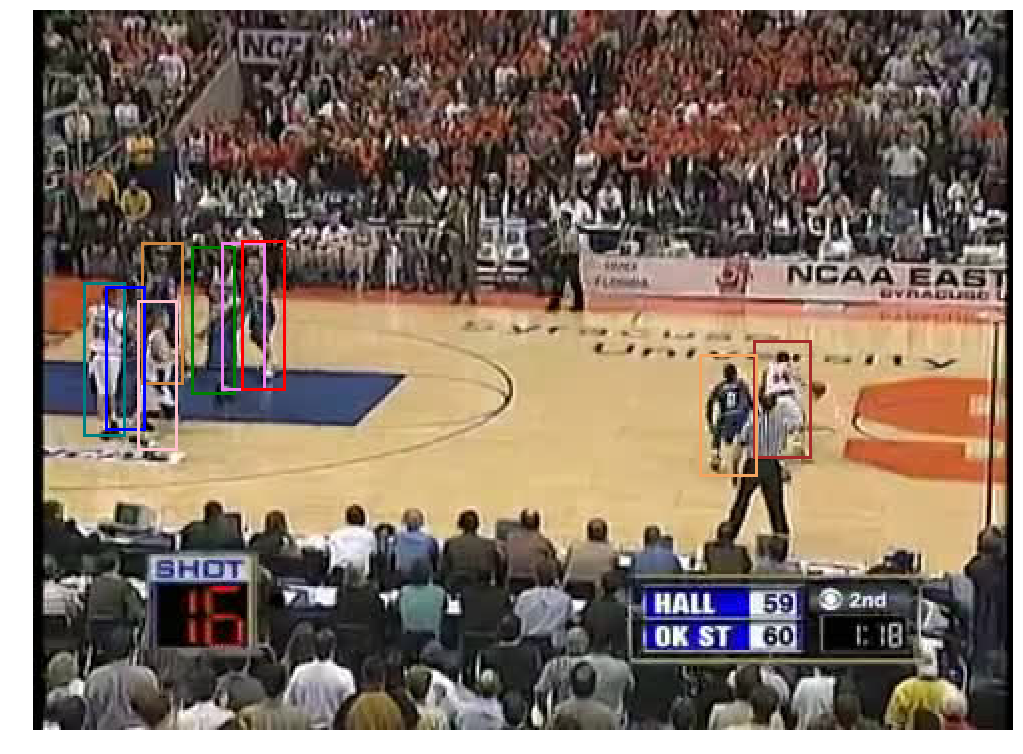

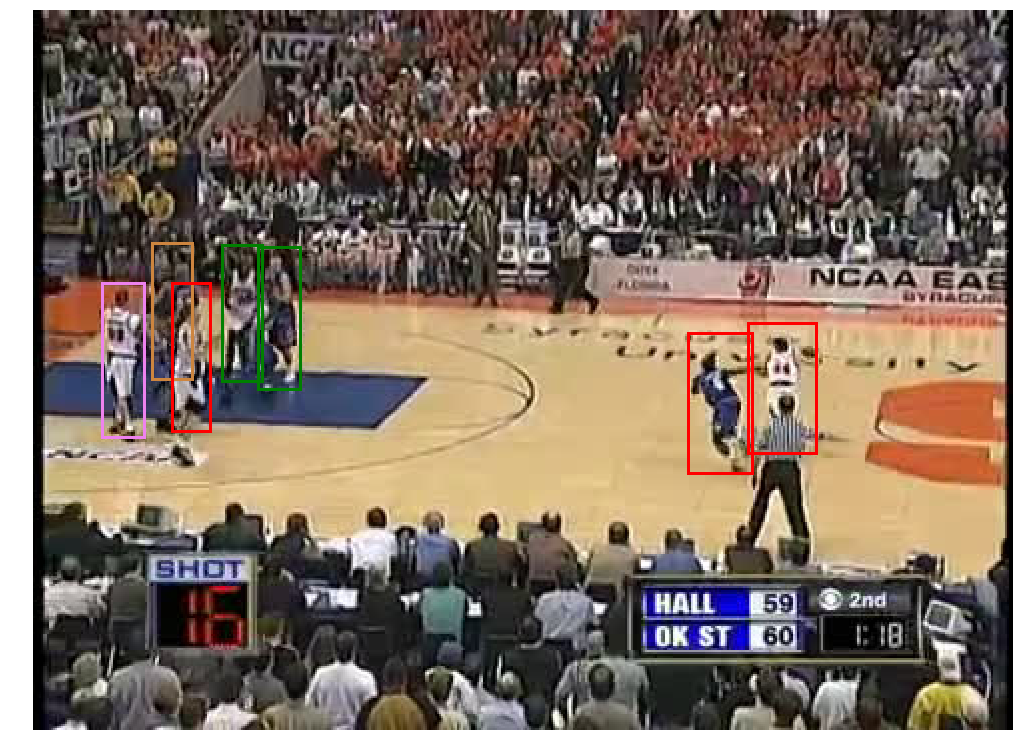

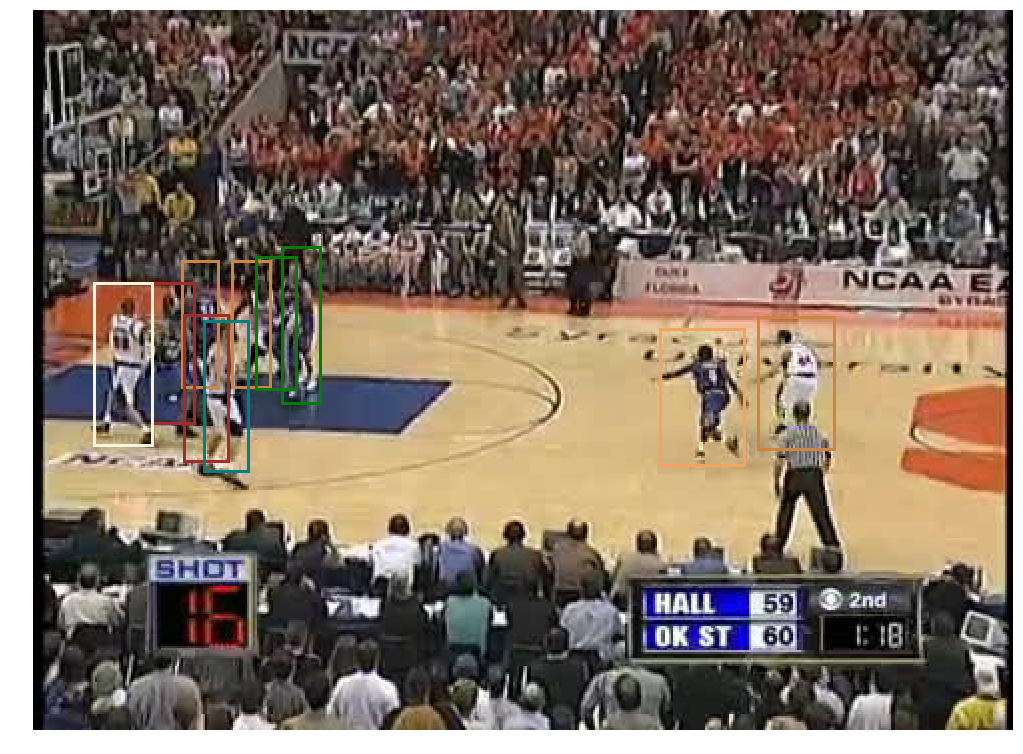

In [649]:
dist_df = calculate_mid_point(csv_file, False)
# calculate_distance_from_each(dist_df)
box = calculate_mid_point(csv_file.iloc[1:,:], False)
# print calculate_dist_between_frame(box, dist_df)

video_id = 'WF0GqBJuBLQ'
clip_id  = 'clip_65'
image_dir = os.path.join(data_dir, video_id, clip_id)
results2 = [name for name in os.listdir(image_dir) if 'png' in name]
results2.sort()

skip_counter = 0
prev_csv_file = ''
players_mid = pd.DataFrame(np.nan, index=range(0,10), columns=['x', 'y'])
for result in results2:
    skip_counter = skip_counter + 1
    #if skip_counter < 1:
    #    continue
    
    result = result.split('.')[0]

    
    csv_name = video_id + '_' + clip_id + '_' + result + '.txt'
    csv_path = os.path.join(results_dir, csv_name)
    csv_file = pd.read_csv(csv_path, header = None)
    
    curr = calculate_mid_point(csv_file)
    if skip_counter == 1:
        players_mid.loc[curr.index, curr.columns] = curr
        assignment = range(0,10)
    else:
        players_mid, assignment = reorder_df(players_mid, curr)
    
    # print skip_counter
    # print overlap_percentage(csv_file)
    produce_image(csv_path, assignment, bounding_box = True ,truth = False)
    prev_csv_file = csv_file
    
    if skip_counter > 2:
        break;

In [ ]:
result_array = []
counter = 0
for result in results:
    csv_path = os.path.join(results_dir, result)
    csv_file = pd.read_csv(csv_path, header = None)
    
    result = overlap_percentage(csv_file)
    result_array = np.append(result_array, result)
    counter = counter + 1
print counter

In [349]:
df = pd.DataFrame(result_array)

                  0
count  51851.000000
mean       0.126082
std        0.101687
min        0.000031
25%        0.042930
50%        0.099654
75%        0.186071
max        0.421559


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f06db98b1d0>]], dtype=object)

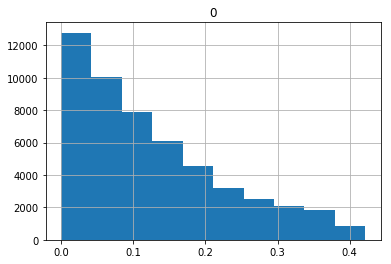

In [353]:
print df.describe()
df.hist()

In [646]:
colour = ['peru', 'green', 'violet', 'red', 'teal', 'blue', 'pink', 'brown', 'sandybrown', 'beige']
def get_video_info(path):
    video_id = re.search('.*(?=(_clip))', path).group(0).split('/')[-1]
    clip_id = re.search('clip_[0-9]{2}', path).group(0)
    frame_number = path[-6:-4]
    
    return video_id, clip_id, frame_number
    
def produce_image(result_csv_path, colour_code, bounding_box = True, truth = False):
    global data_dir
    
    video_id, clip_id, frame_number = get_video_info(result_csv_path)
    
    image_path = os.path.join(data_dir, video_id, clip_id, frame_number + '.png')
    im = mpimg.imread(image_path)
    
    ax = show_image(im)

    if bounding_box == True:
        csv_file = pd.read_csv(result_csv_path, header = None)
        fixed_pd = scale_box(csv_file, im)
        counter = 0
        for index , bbox in fixed_pd.iterrows():
            counter = counter + 1
            rect = patches.Rectangle((bbox.x, bbox.y), bbox.w, bbox.h, linewidth = 3, fill = False, color=colour[colour_code[index]])
            ax.add_patch(rect)
        
    if truth is True:
        bbox_data_path = os.path.join(data_dir, video_id, clip_id, frame_number + '_info.csv')
        bbox_data = pd.read_csv(bbox_data_path)
        print bbox_data_path
        for _, bbox in bbox_data.iterrows():
            rect = patches.Rectangle((bbox.x, bbox.y), bbox.w, bbox.h, linewidth = 3, fill = False, color = 'yellow')
            ax.add_patch(rect)
        

In [647]:
skip_counter = 0
for result in results:
    skip_counter = skip_counter + 1
    if skip_counter < 60:
        continue
    csv_path = os.path.join(results_dir, result)
    print csv_path
    csv_file = pd.read_csv(csv_path, header = None)

    print overlap_percentage(csv_file)
    produce_image(csv_path, bounding_box = True ,truth = True)
    break # REMOVE

../darknet/parse/parsed/WF0GqBJuBLQ_clip_65_13.txt
[0.078868409772824694, 0.37455830388692579, 0.058445728965960182, 0.29402061855670103, 0.008965259618976467, 0.0880690737833595]


TypeError: produce_image() takes at least 2 arguments (3 given)

../darknet/parse/parsed/WF0GqBJuBLQ_clip_65_15.txt
[0.11159107271418287, 0.16730343856826865, 0.08924575490325129, 0.1464318813716404, 0.049558723693143243]
../darknet/parse/parsed/WF0GqBJuBLQ_clip_65_16.txt
[0.19332375373051841, 0.044636531103868497, 0.066405349319806323, 0.052856968065581794]
../darknet/parse/parsed/WF0GqBJuBLQ_clip_65_17.txt
[0.12837710775402744, 0.13996746203904556, 0.38810641627543035, 0.080259547968471012, 0.15887385144615943]
../darknet/parse/parsed/WF0GqBJuBLQ_clip_65_18.txt
[0.10971081354787893, 0.20054945054945056, 0.11429774246171658]
../darknet/parse/parsed/WF0GqBJuBLQ_clip_65_19.txt
[0.38113376652475911, 0.037376902417188898, 0.1732036397866332, 0.37554322390853778, 0.16060089824996129, 0.15561569688768606, 0.32932880647688689, 0.015369110607205845, 0.2547584187408492, 0.018233229329173168]
../darknet/parse/parsed/WF0GqBJuBLQ_clip_65_20.txt
[0.26820067898906075, 0.25936234817813764, 0.0084798994974874375, 0.034903047091412745, 0.31489945155393051, 0.132601

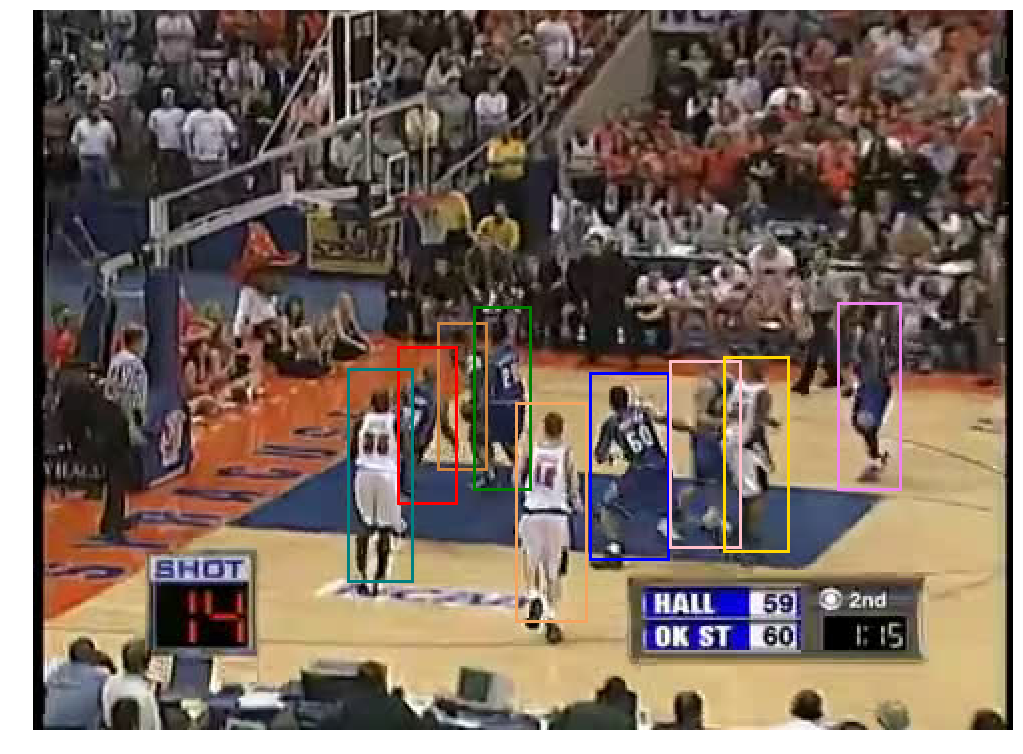

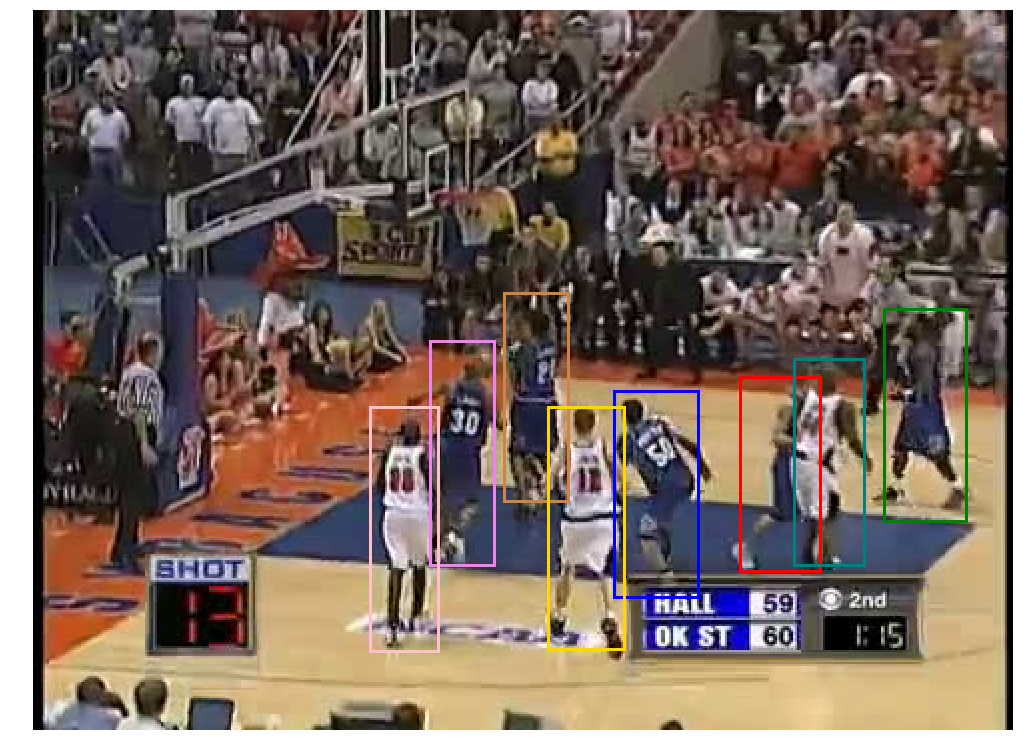

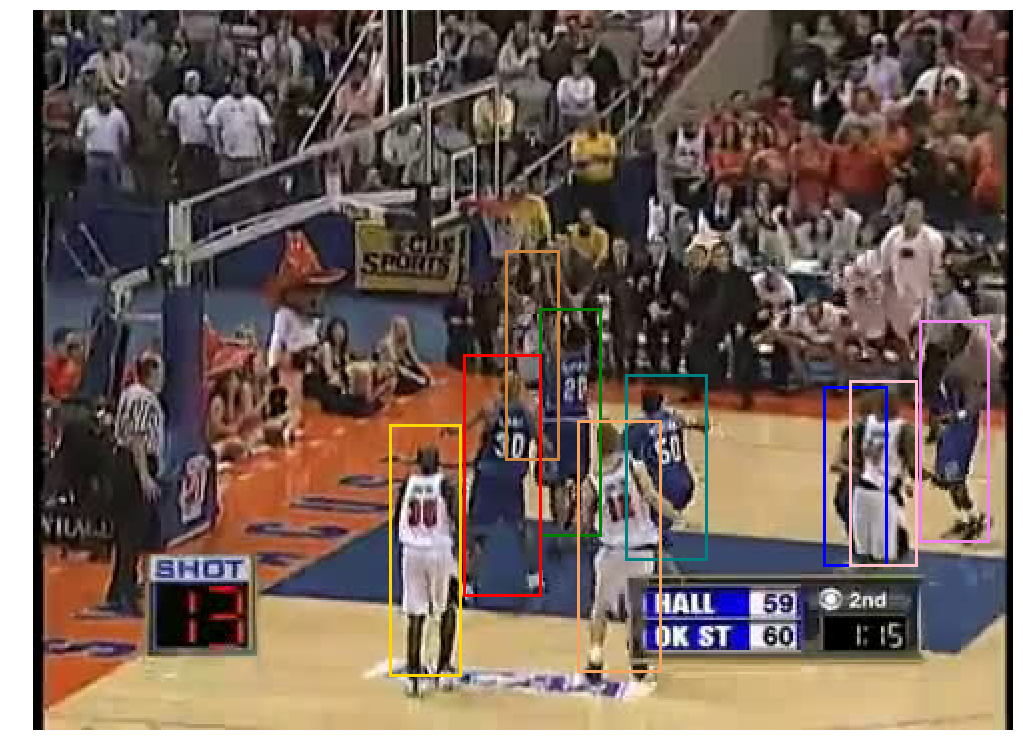

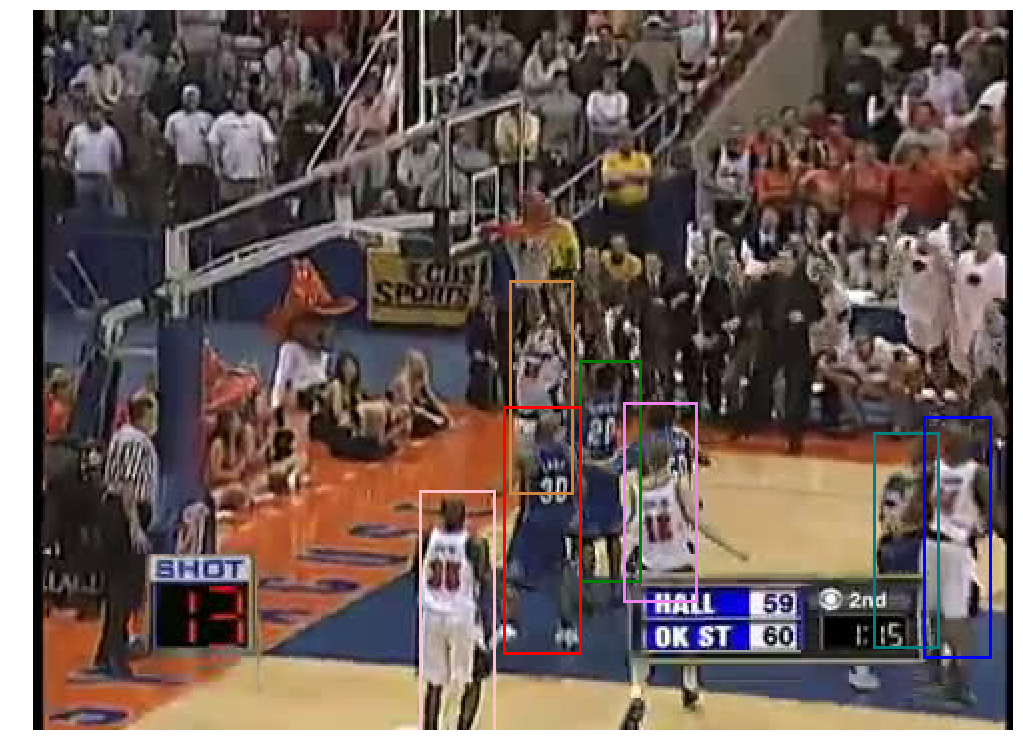

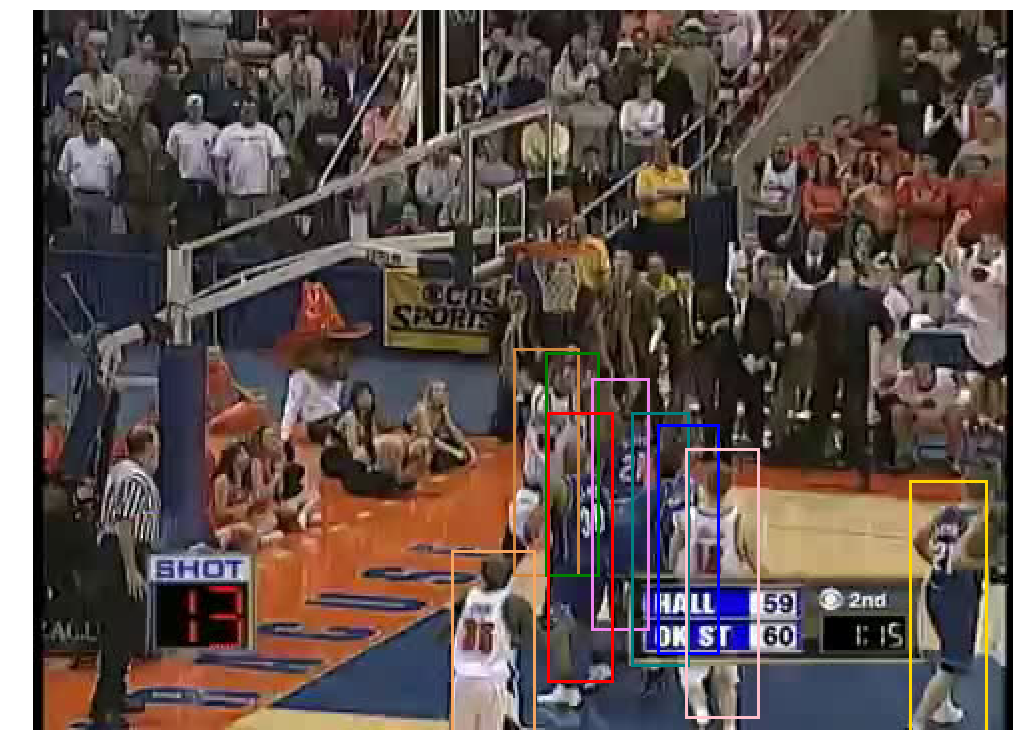

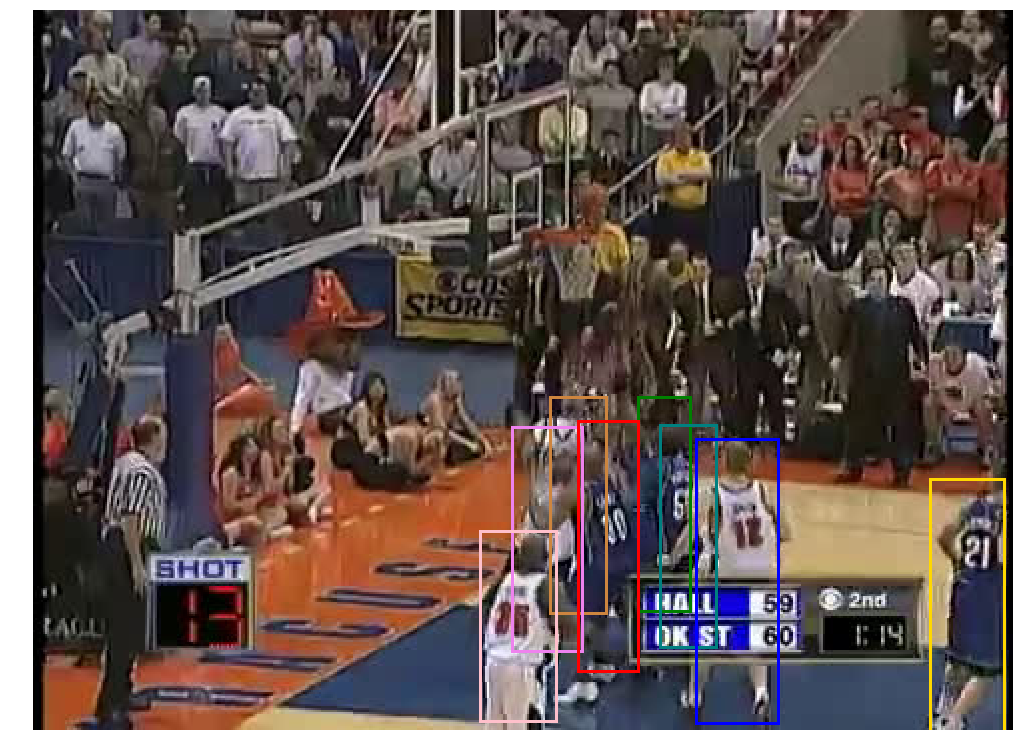

In [473]:
video_id = 'WF0GqBJuBLQ'
clip_id  = 'clip_65'
image_dir = os.path.join(data_dir, video_id, clip_id)
results2 = [name for name in os.listdir(image_dir) if 'png' in name]
results2.sort()

skip_counter = 0
for result in results2:
    result = result.split('.')[0]
    skip_counter = skip_counter + 1
    if skip_counter < 15:
        continue
    csv_name = video_id + '_' + clip_id + '_' + result + '.txt'
    csv_path = os.path.join(results_dir, csv_name)
    print csv_path
    csv_file = pd.read_csv(csv_path, header = None)

    print overlap_percentage(csv_file)
    produce_image(csv_path, bounding_box = True ,truth = False)

In [432]:
print results

['15.png', '12.png', '20.png', '03.png', '04.png', '13.png', '14.png', '05.png', '02.png', '01.png', '06.png', '08.png', '19.png', '17.png', '10.png', '09.png', '07.png', '11.png', '16.png', '18.png']
